In [1]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import oledpy.dipole_emission as diem
from oledpy.dipole_emission import ThinFilmArchitecture
from numpy.lib.scimath import sqrt as csqrt
import warnings
warnings.filterwarnings('ignore')
df_nk=pd.read_csv(os.path.join('Reference Data','nk_library.csv'))

In [2]:
layer_names = ['SiO2','ITO','TCTA','CBP-Irppy','TPBi','Al','Air']
d = [0,100,35,30,40,100,0]
doping = [1,1,1,[0.92,0.08],1,1,1]

In [3]:
layers = [
     {'name':'SiO2'      ,'d':0  ,'doping':1,'coherent':0},
     {'name':'ITO'       ,'d':100,'doping':1,'coherent':1},
     {'name':'TCTA'      ,'d':35 ,'doping':1,'coherent':1},
     {'name':'CBP-Irppy','d':30 ,'doping':[0.92,0.08],'coherent':1,'active':1},
     {'name':'TPBi'      ,'d':40 ,'doping':1,'coherent':1},
     {'name':'Al'        ,'d':100,'doping':1,'coherent':1},
     {'name':'Air'       ,'d':0  ,'doping':1,'coherent':0},
]

In [4]:
wavelengths = np.arange(480,670,5)# Define wavelengths of interest
dipole_positions = [0.9] # dipole planes located near EML/ETL interface
irppy3_PL = np.genfromtxt(os.path.join("Reference Data",'irppy3_intrinsic_pl.csv'),skip_header=1,delimiter=',')
PL_interp = np.interp(wavelengths,irppy3_PL[:,0],irppy3_PL[:,1])
architecture = ThinFilmArchitecture(
    layer_dict_list = layers,
    dipole_positions = dipole_positions,
    tau=1e-6,PLQY=0.95, # Intrinsic exciton lifetime and PL quantum yield of Ir(ppy)3
    vac_wavelengths=wavelengths,pl_spectrum=PL_interp)
architecture.load_nk(df_nk=df_nk)
architecture.run_attribute_checks()

Active layer is: CBP-Irppy. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed


In [5]:
df_nk[['Wavelength (nm)','tpbi_n','tpbi_k']].head()

,Wavelength (nm),tpbi_n,tpbi_k
0,300.0,1.81184,0.55061
1,301.0,1.82532,0.55675
2,302.0,1.83881,0.56289
3,303.0,1.85376,0.56391
4,304.0,1.86871,0.56492


In [6]:
# This grid of wavevectors provides a good balance
# between accuracy and calculation speed
custom_u = np.hstack((np.arange(0,0.75,0.005),
                      np.arange(0.75,1,0.001),
                      np.arange(1+0.001,2,0.002),
                      np.arange(2,10,0.1)))
architecture.init_pds_variables(custom_u=custom_u)

Provided imaginary active layer index. Discarding imaginary part.


In [7]:
architecture.calc_r_and_t()
K_data = architecture.calc_K()

  0%|          | 0/38 [00:00<?, ?lam/s]

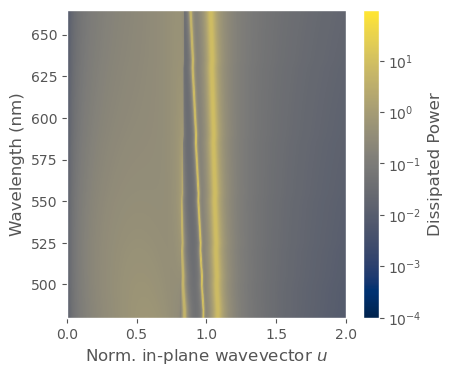

In [8]:
# 2D power dissipation plot
from matplotlib import colors, ticker, cm
with plt.style.context('ggplot'):
    fig,ax=plt.subplots(figsize=(4.5,4))
    u = architecture.u
    K_total_array = K_data['K_total']
    z = u*K_total_array[0,:,:]
    lev_exp = np.arange(-4,#np.floor(np.log10(z[z>0].min())-1)
                        np.ceil(np.log10(z.max())),0.01)
    levs = np.power(10, lev_exp)
    cs = ax.contourf(u,wavelengths, z, levs, 
                norm=colors.LogNorm(),cmap=plt.get_cmap('cividis'))#cividis,#plasma,#viridis
    ticks = 10**np.arange(-4,np.ceil(np.log10(z.max())+1),1) 
    cbar = plt.colorbar(cs,ticks=ticks)
    cbar.set_label('Dissipated Power')
    ax.set_xlabel('Norm. in-plane wavevector $u$')
    ax.set_ylabel('Wavelength (nm)')
    ax.set_xlim(0,2)
    plt.savefig(os.path.join('Plots','power_dissipation_2d.png'),dpi=300,bbox_inches='tight')
    plt.show()